In [35]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import math
import json
import os

import matplotlib.pyplot as plt
import numpy as np

In [36]:
class ModelConfig:
    def __init__(self, patch_size, hidden_size, num_hidden_layers,
                 num_attention_heads, intermediate_size, dropout_prob,
                 attention_dropout_prob, initializer_range, image_size,
                 num_classes, num_channels, use_qkv_bias):
        self.patch_size = patch_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.dropout_prob = dropout_prob
        self.attention_dropout_prob = attention_dropout_prob
        self.initializer_range = initializer_range
        self.image_size = image_size
        self.num_classes = num_classes
        self.num_channels = num_channels
        self.use_qkv_bias = use_qkv_bias



In [37]:
class ImagePatch(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Store configuration parameters
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_channels = config.num_channels
        self.hidden_size = config.hidden_size

        # Calculate the number of patches
        self.num_patches = (self.image_size // self.patch_size) ** 2

        # Create the projection layer (divides the image into patches and projects patches into a vectors)
        self.projection_layer = nn.Conv2d(
            self.num_channels, self.hidden_size, kernel_size=self.patch_size,
            stride=self.patch_size
        )

    def forward(self, images):
        projected = self.projection_layer(images)
        flattened = projected.flatten(2)
        transposed = flattened.transpose(1, 2) # (batch_size, num_patches, hidden_size)
        return transposed


In [38]:
class PositionalEmbedding(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()

        # Create the image patching layer to convert input image into patches
        self.image_patch = ImagePatch(config)

        # Learnable class token (whole image) positional embedding for each patch + class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))
        self.position_embedding = nn.Parameter(torch.randn(1, self.image_patch.num_patches + 1, config.hidden_size))

        # Dropout layer for regularization during training
        self.dropout = nn.Dropout(config.dropout_prob)

    def forward(self, images):
        # Get the patch embeddings for the images
        embeddings = self.image_patch(images)
        batch_size = embeddings.size(0)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1) # resize to match size

        # Concatante class token with patch embeddings, tack on position embeddings
        combined_embeddings = torch.cat((cls_tokens, embeddings), dim=1)
        combined_embeddings += self.position_embedding

        return self.dropout(combined_embeddings)



In [39]:
class SingleAttentionHead(nn.Module):
    def __init__(self, hidden_size, head_size, dropout_rate, bias):
        super().__init__()
        self.hidden_size = hidden_size
        self.head_size = head_size

        # Linear layers to project inputs into query, key, and value vectors
        self.query = nn.Linear(self.hidden_size, self.head_size, bias=bias)
        self.key = nn.Linear(self.hidden_size, self.head_size, bias=bias)
        self.value = nn.Linear(self.hidden_size, self.head_size, bias=bias)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Project the input into query, key, and value vectors
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        # Calculate attention scores, and attention weights
        scores = (query @ key.transpose(-1, -2)) / math.sqrt(self.head_size)
        attention_weights = self.dropout(F.softmax(scores, dim=-1))

        # Weighted sum of value vectors wieghted w/ attention weights
        output = attention_weights @ value

        return output, attention_weights


In [60]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_heads = config.num_attention_heads
        self.head_size = config.hidden_size // self.num_heads
        self.total_head_size = self.num_heads * self.head_size
        self.use_qkv_bias = config.use_qkv_bias

        # Create a list of single attention heads
        self.attention_heads = nn.ModuleList([
            SingleAttentionHead(config.hidden_size, self.head_size, config.attention_dropout_prob, self.use_qkv_bias)
            for _ in range(self.num_heads)
        ])

        # Linear layer to project the concatenated outputs of the attention heads back to the original hidden size
        self.output_layer = nn.Linear(self.total_head_size, config.hidden_size, bias=self.use_qkv_bias)

        # Dropout layer
        self.dropout = nn.Dropout(config.dropout_prob)

    def forward(self, x, return_attention=False):
        # Pass the input through each single attention head
        head_outputs = [head(x) for head in self.attention_heads]

        # Separate outputs and attention weights from each head
        concatenated_output = torch.cat([a for a, _ in head_outputs], dim=-1)
        attention_weights = torch.stack([head for _, head in head_outputs], dim=1) if return_attention else None

        # Project the concatenated outputs back to the original hidden size
        output = self.output_layer(concatenated_output)
        output = self.dropout(output)

        return output, attention_weights


In [41]:
class FeedForwardLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.dropout = nn.Dropout(config.dropout_prob)

    def forward(self, x):
        # Forward pass of the FFN layer
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)

        return self.dropout(x)


In [51]:
class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadedAttention(config)
        self.norm1 = nn.LayerNorm(config.hidden_size)
        self.feed_forward = FeedForwardLayer(config)
        self.norm2 = nn.LayerNorm(config.hidden_size)

    def forward(self, x, return_attention):
        # Self-attention layer
        attn_output, attn_weights = self.attention(self.norm1(x), return_attention=return_attention)
        x = x + attn_output # residual connection

        # Feed-forward layer
        ffn_output = self.feed_forward(self.norm2(x))
        x = x + ffn_output # residutal connection

        return x, (attn_weights if return_attention else None)


In [52]:
class TransformerEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Initialize a list of Transformer blocks
        self.blocks = nn.ModuleList([TransformerBlock(config) for _ in range(config.num_hidden_layers)])

    def forward(self, x, return_attention=False):
        attention_probs = []

        # Run the input through each block sequentially
        for block in self.blocks:
            x, attn = block(x, return_attention=return_attention)
            attention_probs.append(attn)
        return x, (attention_probs if return_attention else None)


In [53]:
class VisionTransformerClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = PositionalEmbedding(config)                                    # Positional embedding layer
        self.encoder = TransformerEncoder(config)                                       # Transformer encoder
        self.classification_head = nn.Linear(config.hidden_size, config.num_classes)    # Classification head

        # Initialize the weights
        self.apply(self._initialize_weights)

    def forward(self, images, return_attention=False):
        # Process the input images and extract patch embeddings
        x = self.embedding(images)

        # Encode the patch embeddings using the Transformer encoder
        x, attention_probs = self.encoder(x, return_attention=return_attention)

        # Extract the first token (representing the entire image) and project it to class logits
        logits = self.classification_head(x[:, 0, :]) # Select the first token (CLS)

        return logits, attention_probs

    def _initialize_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            nn.init.normal_(module.weight, mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, PositionalEmbedding):
            module.position_embedding.data = nn.init.trunc_normal_(
                module.position_embedding.data.to(torch.float32),
                mean=0.0, std=self.config.initializer_range).to(module.position_embedding.dtype)
            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0, std=self.config.initializer_range).to(module.cls_token.dtype)

# Code to Train

In [45]:
class ModelTrainer:
    def __init__(self, model, optimizer, loss_fn, device, model_config):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.config = model_config
        self.train_losses = []
        self.test_losses = []
        self.accuracies = []

    def train(self, train_loader, test_loader, num_epochs):
        # Initialize accurayc and loss lists
        train_losses = self.train_losses = []
        test_losses = self.test_losses = []
        accuracies = self.accuracies = []

        for epoch in range(num_epochs):
            # Train for one epoch
            epoch_loss = self._train_single_epoch(train_loader)
            accuracy, epoch_test_loss = self._evaluate(test_loader)

            # Track accuracy, train/test losses
            train_losses.append(epoch_loss)
            test_losses.append(epoch_test_loss)
            accuracies.append(accuracy)

            # Output epoch result
            print(f"Epoch: {epoch + 1}, Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Accuracy: {accuracy:.4f}")


    def _train_single_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0

        # Train one batch
        for batch in train_loader:
            images, labels = [item.to(self.device) for item in batch]
            self.optimizer.zero_grad()
            logits = self.model(images)[0]
            loss = self.loss_fn(logits, labels)

            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * images.size(0)

        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def _evaluate(self, test_loader):
        self.model.eval()
        total_loss, correct_predictions = 0.0, 0

        # Use test set for test validation
        for batch in test_loader:
            images, labels = [item.to(self.device) for item in batch]
            logits, _ = self.model(images)

            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * images.size(0)

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()

        # Calculate accuracy and loss
        accuracy = correct_predictions / len(test_loader.dataset)
        average_loss = total_loss / len(test_loader.dataset)

        return accuracy, average_loss

# Preparing the Data

In [46]:
def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    # Structure, trnasform, and prep images for training the model
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    if train_sample_size:
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    # Structure data and prep images for model test validation
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    if test_sample_size:
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader


# Time to Train

In [73]:
model_config = ModelConfig(
    patch_size=4,
    hidden_size=48,
    num_hidden_layers=4,
    num_attention_heads=4,
    intermediate_size=4*48,
    dropout_prob=0.0,
    attention_dropout_prob=0.0,
    initializer_range=0.02,
    image_size=32,
    num_classes=10,
    num_channels=3,
    use_qkv_bias=True,
)

# Training parameters
batch_size = 256
learning_rate = 0.01
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 50

# Prepare data and model
train_loader, test_loader = prepare_data(batch_size=batch_size)

model = VisionTransformerClassifier(model_config)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Start training
trainer = ModelTrainer(model, optimizer, loss_fn, device, model_config)
trainer.train(train_loader, test_loader, num_epochs)

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Train Loss: 1.9176, Test Loss: 1.7467, Accuracy: 0.3462
Epoch: 2, Train Loss: 1.5949, Test Loss: 1.5189, Accuracy: 0.4600
Epoch: 3, Train Loss: 1.4570, Test Loss: 1.3790, Accuracy: 0.5000
Epoch: 4, Train Loss: 1.3696, Test Loss: 1.3204, Accuracy: 0.5177
Epoch: 5, Train Loss: 1.3026, Test Loss: 1.3628, Accuracy: 0.5087
Epoch: 6, Train Loss: 1.2590, Test Loss: 1.2004, Accuracy: 0.5636
Epoch: 7, Train Loss: 1.2196, Test Loss: 1.2913, Accuracy: 0.5375
Epoch: 8, Train Loss: 1.1784, Test Loss: 1.1854, Accuracy: 0.5668
Epoch: 9, Train Loss: 1.1467, Test Loss: 1.1965, Accuracy: 0.5726
Epoch: 10, Train Loss: 1.1319, Test Loss: 1.1607, Accuracy: 0.5825
Epoch: 11, Train Loss: 1.1030, Test Loss: 1.0997, Accuracy: 0.6052
Epoch: 12, Train Loss: 1.0832, Test Loss: 1.0862, Accuracy: 0.6172
Epoch: 13, Train Loss: 1.0449, Test Loss: 1.0437, Accuracy: 0.6213
Epoch: 14, Train Loss: 1.0305, Test Loss: 1.0652, Accuracy: 0.

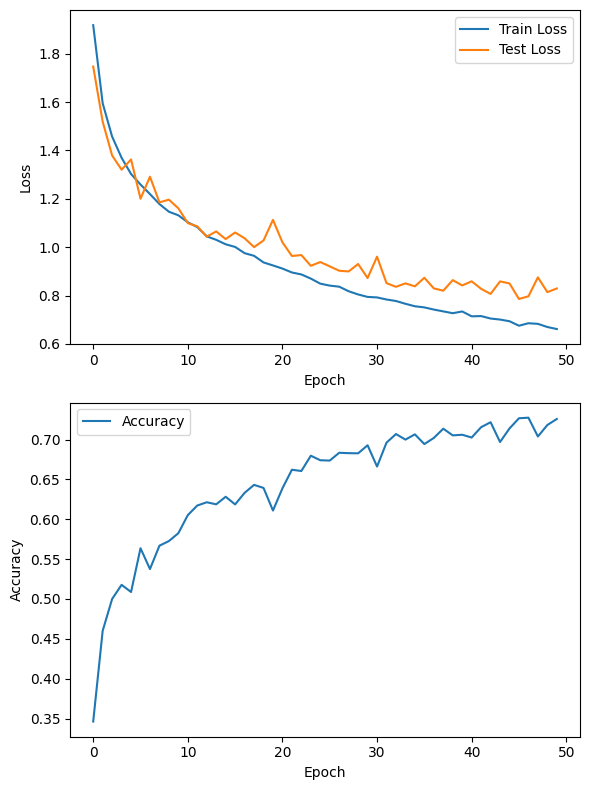

In [96]:
import matplotlib.pyplot as plt

train_losses = trainer.train_losses
test_losses = trainer.test_losses
accuracies = trainer.accuracies

fig, axs = plt.subplots(2, 1, figsize=(6, 8))

axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(accuracies, label='Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
torch.Size([10, 16, 65, 65])
torch.Size([10, 16, 64])


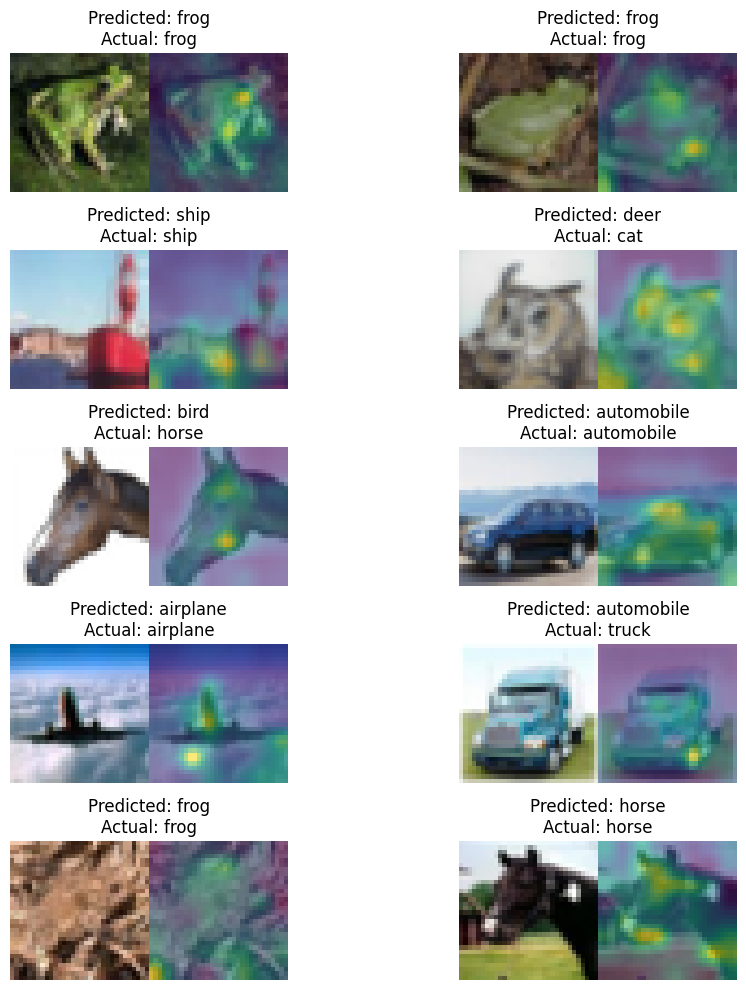

In [94]:
import numpy as np

model = trainer.model
model.eval()

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
cls_names = testset.classes

# pick 20 images at random
indices = torch.randperm(len(testset))[:10]
images_t = [np.asarray(testset[i][0]) for i in indices]
labels = [testset[i][1] for i in indices]

# predict the class of each image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

images = torch.stack([transform(image) for image in images_t])
logits, attn_map = model(images.to(device), return_attention=True)
predictions = torch.argmax(logits, dim=1)


attn_map = torch.cat(attn_map, dim=1)
print(attn_map.size())
attn_map = attn_map[:, :, 0, 1:]
print(attn_map.size())
attn_map = attn_map.mean(dim=1)

square_size = int(math.sqrt(attn_map.size(-1)))
attn_map = attn_map.view(-1, square_size, square_size)
attn_map = F.interpolate(attn_map.unsqueeze(1), size=(32, 32), mode='bilinear', align_corners=False).squeeze(1)

# display attention maps
fig = plt.figure(figsize=(10, 10))
mask = np.concatenate([np.ones((32, 32)), np.zeros((32, 32))], axis=1)
for i in range(len(images_t)):
    ax = fig.add_subplot(5, 2, i + 1)
    stacked_img = np.concatenate((images_t[i], images_t[i]), axis=1)
    ax.imshow(stacked_img)
    shifted_attn_map = np.concatenate((np.zeros((32, 32)), attn_map[i].cpu().detach().numpy()), axis=1)
    shifted_attn_map = np.ma.masked_where(mask==1, shifted_attn_map)
    ax.imshow(shifted_attn_map, cmap='viridis', alpha=0.6)

    ax.set_title(f'Predicted: {cls_names[predictions[i]]}\nActual: {cls_names[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()